In [23]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

def print_accuracy(cm):
    acc = np.diagonal(cm.values).sum() /cm.values.sum()
    print(f"Accuracy: {acc}")
    return acc

## Lidar predictions - get polygon

In [101]:
UNION_PREDICTIONS_DIR = Path("/mnt/store-lidarhd/projet-LHD/IA/Analyses/20240122_compare_polygon_cm/PureForestID-V2-Baseline-single-tree-block-aggregation-nocolor-GenericDA-3x2GPUs-best_epoch_085/")
df_lidar = pd.read_csv(UNION_PREDICTIONS_DIR / "predictions-pivot-by-polygon.csv", index_col=0)
df_lidar.head()

,bdforetv2_id,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-51-51_Pin_maritime,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Epicéa,FF2G61-61_Sapin,consensus,accurate
0,FORESTIE0000000000100093,FF1-14-14_Robinier,0,0,8,0,0,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
1,FORESTIE0000000000100104,FF1-14-14_Robinier,0,0,29,0,0,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
2,FORESTIE0000000000100240,FF1-14-14_Robinier,0,0,7,0,0,0,0,0,0,0,0,0,0,FF1-14-14_Robinier,True
3,FORESTIE0000000000401455,FF1G01-01_Chêne_décidus,1,0,0,124,21,0,0,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True
4,FORESTIE0000000000402323,FF1G01-01_Chêne_décidus,23,1,0,415,183,0,1,0,0,0,0,0,0,FF1G01-01_Chêne_décidus,True


In [120]:
df_lidar[df_lidar.targets.str.contains("Sapin")]

,bdforetv2_id,geometry,targets,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-51-51_Pin_maritime,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Epicéa,FF2G61-61_Sapin,consensus,accurate
94,FORESTIE0000000004814638,"MULTIPOLYGON (((754298.975 6403562.571, 754312...",FF2G61-61_Sapin,0,0,0,0,0,0,0,0,0,0,0,22,0,FF2G61-61_Epicéa,False
100,FORESTIE0000000006316380,"MULTIPOLYGON (((677097.951 6493843.225, 677100...",FF2G61-61_Sapin,3,0,0,0,0,0,2,0,0,4,0,713,0,FF2G61-61_Epicéa,False


### Recover polygone geometry

In [102]:
annotations = gpd.read_file("/mnt/store-lidarhd/projet-LHD/IA/BDForet/Data/PureForestV2-sources/dataset.gpkg")
annotations = annotations[annotations.split.isin(["test","val"])]
# We merge when a bd foret polygon was splitted into n polygons of the same species
annotations = annotations.dissolve(by=["bdforetv2_id","bdforetv2_tfv"], as_index=False)
annotations = annotations[["bdforetv2_id","geometry"]]
print(len(annotations))
df_lidar = annotations.merge(df_lidar, on="bdforetv2_id",how="right")
# df_lidar

133


In [124]:
pivot_counts_by_class = df_lidar[[c for c in df_lidar.columns if c.startswith("FF")]]
pivot_freq_by_class = pivot_counts_by_class.div(pivot_counts_by_class.sum(axis=1), axis=0)
lidar_ensembling = df_lidar[["bdforetv2_id","geometry","targets"]].copy()
lidar_ensembling["predicted_essence_bdforetv3_lidar"] = pd.Series(pivot_freq_by_class.transpose().to_dict())
lidar_ensembling.head()

,bdforetv2_id,geometry,targets,predicted_essence_bdforetv3_lidar
0,FORESTIE0000000000100093,"POLYGON ((850378.523 6529213.988, 850388.060 6...",FF1-14-14_Robinier,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."
1,FORESTIE0000000000100104,"POLYGON ((856048.010 6530279.728, 856055.210 6...",FF1-14-14_Robinier,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."
2,FORESTIE0000000000100240,"POLYGON ((858559.904 6530793.338, 858561.650 6...",FF1-14-14_Robinier,"{'FF1-09-09_Hêtre': 0.0, 'FF1-10-10_Châtaignie..."
3,FORESTIE0000000000401455,"POLYGON ((908320.995 6324608.637, 908348.777 6...",FF1G01-01_Chêne_décidus,"{'FF1-09-09_Hêtre': 0.00684931506849315, 'FF1-..."
4,FORESTIE0000000000402323,"POLYGON ((934086.387 6342946.997, 934090.996 6...",FF1G01-01_Chêne_décidus,"{'FF1-09-09_Hêtre': 0.03691813804173355, 'FF1-..."


### Get corresponding annotations polygons to have fair comparison with image model

## Modèle Image

In [152]:
import ast
# Rename to order similarly
remapper = {"Chêne sempervirent":"FF1G06-06_Chêne_sempervirent",
"Pin d'Alep":"FF2-57-57_Pin_alep",
"Mélèze":"FF2-63-63-Mélèze",
"Epicéa":"FF2G61-61_Epicéa",
"Sapin":"FF2G61-61_Sapin",
"Robinier":"FF1-14-14_Robinier",
"Pin sylvestre":"FF2-52-52_Pin_sylvestre",
"Hêtre":"FF1-09-09_Hêtre",
"Pin maritime":"FF2-51-51_Pin_maritime",
"Pin laricio, pin noir":"FF2G53-53_Pin_laricio_Pin_noir",
"Chêne décidu":"FF1G01-01_Chêne_décidus",
"Douglas":"FF2-64-64_Douglas",
"Chataîgnier":"FF1-10-10_Châtaignier",
'Non forêt':'Non forêt'
}

FLAIR2_RESULTS_DIR = Path("/mnt/store-lidarhd/projet-LHD/IA/Analyses/20240122_compare_polygon_cm/version_4_dataset_subset1000/")
df_flair2 = gpd.read_file(FLAIR2_RESULTS_DIR / "predictions_version_4_val_test.gpkg")
df_flair2["actual_essence_bdforetv3"] = df_flair2["actual_essence_bdforetv3"].apply(lambda x : remapper[x])
df_flair2["predicted_essence_bdforetv3"] = df_flair2["predicted_essence_bdforetv3"].apply(lambda x : remapper[x])
df_flair2["percent_votes"] = df_flair2["percent_votes"].apply(lambda votes : {remapper[key]:value/100 for key,value in ast.literal_eval(votes).items()})
df_flair2["absolute_votes"] = df_flair2["absolute_votes"].apply(lambda votes : {remapper[key]:value for key,value in ast.literal_eval(votes).items()})
# df_flair2.head()

In [153]:
# Take only cmmon parts of the predictions (Lidar may be smaller due to data construction)
df_flair2 = gpd.overlay(lidar_ensembling[["geometry","bdforetv2_id"]],df_flair2)
df_flair2["shared_area"] = df_flair2.area
df_flair2 = df_flair2.sort_values("shared_area",ascending=False) # keep the one with max overlay, the other is almost null.
df_flair2 = df_flair2.dissolve(by="bdforetv2_id")
print(len(df_flair2))
df_flair2.head()

119


/tmp/ipykernel_3399796/1040036299.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  df_flair2 = gpd.overlay(lidar_ensembling[["geometry","bdforetv2_id"]],df_flair2)


,geometry,annotation_id,actual_class,predicted_class,actual_code_essence_inventaire,actual_essence_inventaire,actual_code_essence_bdforetv3,actual_essence_bdforetv3,predicted_code_essence_bdforetv3,predicted_essence_bdforetv3,absolute_votes,percent_votes,annotation_area_km2,shared_area
bdforetv2_id,,,,,,,,,,,,,,
FORESTIE0000000000100093,"POLYGON ((850388.060 6529196.504, 850415.055 6...",731,4,4,14,Robinier faux acacia,14,FF1-14-14_Robinier,14,FF1-14-14_Robinier,"{'FF1G01-01_Chêne_décidus': 94039.0, 'FF1G06-0...","{'FF1G01-01_Chêne_décidus': 0.0255, 'FF1G06-06...",0.077936,7.793573e+04
FORESTIE0000000000100104,"POLYGON ((856055.210 6530277.234, 856061.351 6...",733,4,3,14,Robinier faux acacia,14,FF1-14-14_Robinier,10,FF1-10-10_Châtaignier,"{'FF1G01-01_Chêne_décidus': 8197.0, 'FF1G06-06...","{'FF1G01-01_Chêne_décidus': 0.00084, 'FF1G06-0...",0.225836,2.258361e+05
FORESTIE0000000000100240,"POLYGON ((858561.650 6530808.670, 858581.262 6...",737,4,4,14,Robinier faux acacia,14,FF1-14-14_Robinier,14,FF1-14-14_Robinier,"{'FF1G01-01_Chêne_décidus': 1487.0, 'FF1G06-06...","{'FF1G01-01_Chêne_décidus': 0.00041, 'FF1G06-0...",0.080615,8.061523e+04
FORESTIE0000000000401455,"POLYGON ((908348.777 6324599.112, 908371.002 6...",37,0,0,05,Chêne pubescent,01,FF1G01-01_Chêne_décidus,01,FF1G01-01_Chêne_décidus,"{'FF1G01-01_Chêne_décidus': 17064086.0, 'FF1G0...","{'FF1G01-01_Chêne_décidus': 0.97859, 'FF1G06-0...",0.525032,5.250322e+05
FORESTIE0000000000402323,"POLYGON ((934090.996 6342943.157, 934106.871 6...",151,0,2,05,Chêne pubescent,01,FF1G01-01_Chêne_décidus,09,FF1-09-09_Hêtre,"{'FF1G01-01_Chêne_décidus': 32483636.0, 'FF1G0...","{'FF1G01-01_Chêne_décidus': 0.4138, 'FF1G06-06...",2.537976,2.537976e+06


In [154]:
df_flair2[df_flair2.actual_essence_bdforetv3.str.contains("Sapin")]

,geometry,annotation_id,actual_class,predicted_class,actual_code_essence_inventaire,actual_essence_inventaire,actual_code_essence_bdforetv3,actual_essence_bdforetv3,predicted_code_essence_bdforetv3,predicted_essence_bdforetv3,absolute_votes,percent_votes,annotation_area_km2,shared_area
bdforetv2_id,,,,,,,,,,,,,,
FORESTIE0000000004814638,"MULTIPOLYGON (((754328.079 6403539.288, 754347...",586,9,10,61,Sapin pectiné,61,FF2G61-61_Sapin,62,FF2G61-61_Epicéa,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...",0.110587,1.105875e+05
FORESTIE0000000006316380,"MULTIPOLYGON (((677102.000 6493865.800, 677107...",150,9,10,61,Sapin pectiné,61,FF2G61-61_Sapin,62,FF2G61-61_Epicéa,"{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...","{'FF1G01-01_Chêne_décidus': 0.0, 'FF1G06-06_Ch...",5.554646,5.554646e+06


In [155]:
# Confusion matrix at polygon level
counts = df_flair2.groupby(["actual_essence_bdforetv3","predicted_essence_bdforetv3"]).size().reset_index().rename(columns={0:"count"})
cm = counts.pivot(index="actual_essence_bdforetv3",columns="predicted_essence_bdforetv3",values="count").fillna(0).astype(int)
cm.insert(12,"FF2G61-61_Sapin",np.zeros(13))
print_accuracy(cm)
cm

Accuracy: 0.7563025210084033


predicted_essence_bdforetv3,FF1-09-09_Hêtre,FF1-10-10_Châtaignier,FF1-14-14_Robinier,FF1G01-01_Chêne_décidus,FF1G06-06_Chêne_sempervirent,FF2-51-51_Pin_maritime,FF2-52-52_Pin_sylvestre,FF2-57-57_Pin_alep,FF2-63-63-Mélèze,FF2-64-64_Douglas,FF2G53-53_Pin_laricio_Pin_noir,FF2G61-61_Epicéa,FF2G61-61_Sapin
actual_essence_bdforetv3,,,,,,,,,,,,,
FF1-09-09_Hêtre,8,0,0,0,0,0,0,0,0,0,0,0,0.0
FF1-10-10_Châtaignier,0,3,0,2,0,0,0,0,0,0,0,0,0.0
FF1-14-14_Robinier,0,2,16,6,0,0,0,0,0,0,0,0,0.0
FF1G01-01_Chêne_décidus,3,0,0,22,1,0,2,0,0,0,0,0,0.0
FF1G06-06_Chêne_sempervirent,0,0,0,0,10,0,0,0,0,0,0,0,0.0
FF2-51-51_Pin_maritime,0,0,0,0,0,5,0,0,0,0,2,0,0.0
FF2-52-52_Pin_sylvestre,0,0,0,1,0,1,9,0,0,0,1,0,0.0
FF2-57-57_Pin_alep,0,0,0,0,0,0,0,4,0,0,0,0,0.0
FF2-63-63-Mélèze,0,0,0,0,0,0,0,0,2,0,0,0,0.0


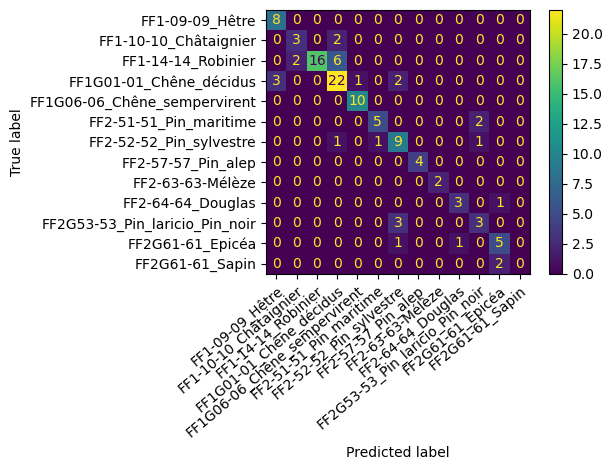

In [156]:
ConfusionMatrixDisplay(cm.values, display_labels=cm.index.values).plot()
import matplotlib.pyplot as plt
plt.xticks(rotation = 40,  rotation_mode="anchor",ha='right') # Rotates X-Axis Ticks by 45-degrees
# plt.show()
plt.tight_layout()
plt.savefig(FLAIR2_RESULTS_DIR / "CM-by-polygon-val-and-test-Flair2.png")